In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots;
import NLsolve,Roots;
# pyplot(frame=:box,size=(500,350));
# set default values for the pyplot backend of Plots
pyplot(frame=:box, minorticks=5, size=(500,350), titlefont = (11,"serif"), 
    guidefont = (12,"serif"), tickfont = (11,"serif"), legendfont= (9, "serif"),
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto) 
# # mathtext.fontset; supported: ['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
# PyPlot.matplotlib.rc("mathtext", fontset="cm")      
# PyPlot.matplotlib.rc("font", family="serif", size=11)

Plots.PyPlotBackend()

In [2]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potential.jl");

In [3]:
function quadgauss(f, x::T, w::T) where {T<:Vector{Float64}}
    res = zero(f(x[1]))  # zero of the same type as f(x[1]), to avoid type instability
    for i in eachindex(x)
        res += f(x[i]) * w[i]
    end
    return res
end

λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end
xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)

xsqrt1 (generic function with 1 method)

# serveral cuts

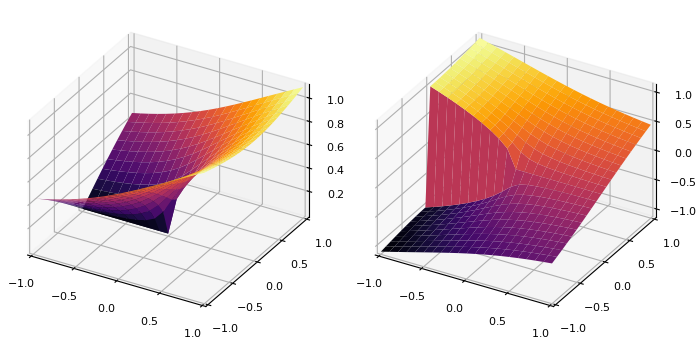

In [4]:
let xv=collect(-1:0.1:1.0),yv=collect(-1:0.1:1.0)
    resv=[sqrt(x+im*y+im*eps()) for y in yv,x in xv]
    p1=surface(xv,yv,real.(resv),legend=:false)
    p2=surface(xv,yv,imag.(resv),legend=:false)
    plot(p1,p2,layout=(1,2),size=(700,350))
end

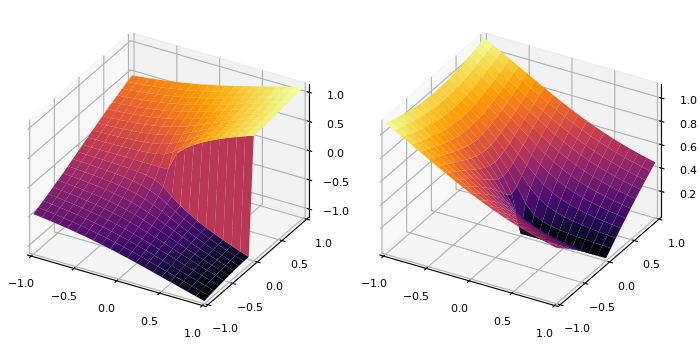

In [5]:
let xv=collect(-1:0.1:1.0),yv=collect(-1:0.1:1.0)
    resv=[xsqrt(x+im*y+im*eps()) for y in yv,x in xv]
    p1=surface(xv,yv,real.(resv),legend=:false)
    p2=surface(xv,yv,imag.(resv),legend=:false)
    plot(p1,p2,layout=(1,2),size=(700,350))
end

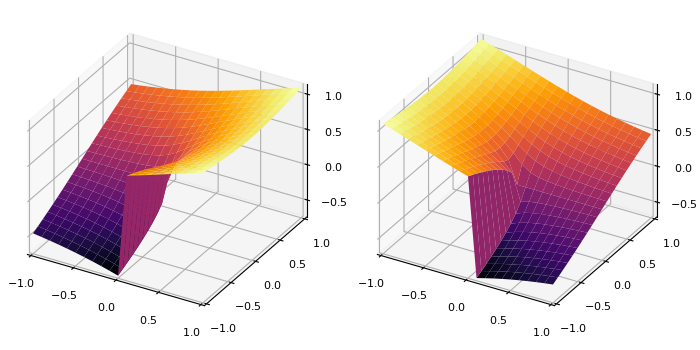

In [6]:
let xv=collect(-1:0.1:1.0),yv=collect(-1:0.1:1.0)
    xsqrt1(x)= (imag(x)<0&&real(x)>0) ? -xsqrt(x) : xsqrt(x)
    resv=[xsqrt1(x+im*y+im*eps()) for y in yv,x in xv]
    p1=surface(xv,yv,real.(resv),legend=:false)
    p2=surface(xv,yv,imag.(resv),legend=:false)
    plot(p1,p2,layout=(1,2),size=(700,350))
end

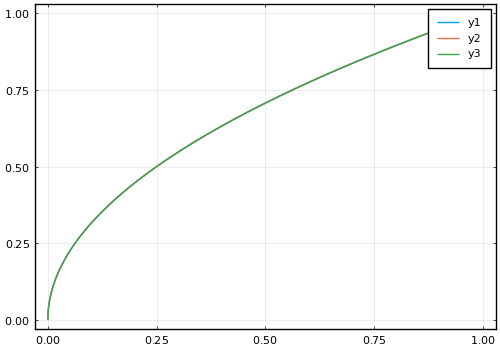

In [7]:
plot(sqrt,0,1)
plot!(xsqrt,0,1)
plot!(xsqrt1,0,1)

# width of $D^*$

In [4]:
function Γf(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im) : xsqrt(2*μ*(E1-m1-m2)+0im)
end

function Γf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -xsqrt(2*μ*(E1-m1-m2)+0im)^3 : xsqrt(2*μ*(E1-m1-m2)+0im)^3
end

function dΓf3(E,q,m1,m2,m3,m12)
    E1=E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
    μ=(m1*m2)/(m1+m2)
    tmp=-3*μ*xsqrt(2*μ*(E1-m1-m2)+0im)*(q/sqrt(m12^2+q^2+0im)+q/sqrt(m3^2+q^2+0im))
    return (imag(E1)<0&&real(E1)>(m1+m2)) ? -tmp : tmp
end

dΓf3 (generic function with 1 method)

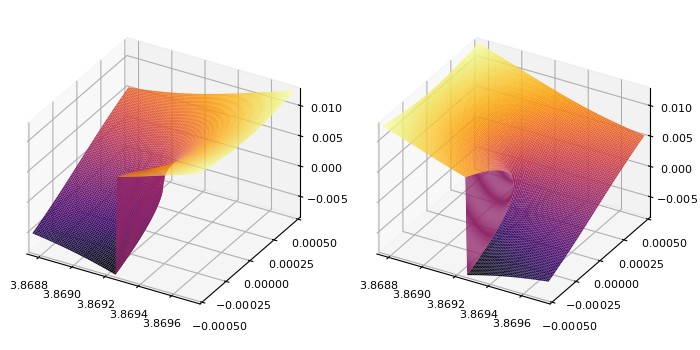

In [9]:
let Ev=collect(2mDn+mπc-500e-6:10e-6:2mDn+mπc+500e-6),Γv=collect(-500e-6:10e-6:500e-6)
    resv=[Γf(e+im*γ,0,mDn,mπc,mDn,mDsc) for γ in Γv,e in Ev]
    p1=surface(Ev,Γv,real.(resv),legend=:false)
    p2=surface(Ev,Γv,imag.(resv),legend=:false)
    plot(p1,p2,layout=(1,2),size=(700,350))
end

In [5]:
ΓDscf(E, p) = (ΓRDsc + g^2 * mDn / (6 * π * fπ^2 * mDsc) * Γf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * Γf3(E, p, mDc, mπn, mDn,mDsc))

ΓDsnf(E, p) = (ΓRDsn + g^2 * mDn / (12 * π * fπ^2 * mDsn) * Γf3(E, p, mDn, mπn, mDc,mDsn)
                                   + g^2 * mDc / (6 * π * fπ^2 * mDsn) * (Γf3(E, p, mDc, mπc, mDc,mDsn) - Γf3(mDc + mDsn, 0, mDc, mπc, mDc,mDsn)))

dΓDscf(E, p) = (g^2 * mDn / (6 * π * fπ^2 * mDsc) * dΓf3(E, p, mDn, mπc, mDn,mDsc)
                                   + g^2 * mDc / (12 * π * fπ^2 * mDsc) * dΓf3(E, p, mDc, mπn, mDn,mDsc))

dΓDsnf(E, p) = (g^2 * mDn / (12 * π * fπ^2 * mDsn) * dΓf3(E, p, mDn, mπn, mDc,mDsn)+ g^2 * mDc / (6 * π * fπ^2 * mDsn) * dΓf3(E, p, mDc, mπc, mDc,mDsn))

dΓDsnf (generic function with 1 method)

In [6]:
function find_singular(E, den; pstart = [0.01, 0.01])
    function f!(F, x)
        pr, pi = x
        tmp = den(E, pr + im * pi)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    sol = NLsolve.nlsolve((F, x) -> f!(F, x), pstart)
    @assert sol.residual_norm < 1e-8 "The on-shell momentum not found!"
    return sol.zero[1] + im * sol.zero[2]
#     return sol.residual_norm < 1e-8 ? sol.zero[1] + im * sol.zero[2] : NaN+im*NaN
end

find_singular (generic function with 1 method)

In [7]:
qon_c(E)=find_singular(E, (E, p) -> E-mDn-mDsc - p^2 / (2 * μf(mDn, mDsc)) + im * ΓDscf(E, p) / 2; pstart = [reim(xsqrt1(E-mDn-mDsc + im * ΓDsc / 2))...])

qon_0(E)=find_singular(E, (E, p) -> E-mDc-mDsn - p^2 / (2 * μf(mDc, mDsn)) + im * ΓDsnf(E, p) / 2; pstart = [reim(xsqrt1(E-mDc-mDsn + im * ΓDsn / 2))...])

qon_0 (generic function with 1 method)

In [13]:
qon_c(3.875+im*eps())|>println
qon_c(3.875-im*eps())|>println

0.0029372246221008136 + 0.014184313944713145im
0.002937224622071771 + 0.014184313944707129im


In [14]:
qon_0(3.875+im*eps())|>println
qon_0(3.875-im*eps())|>println

0.0005089301587534263 + 0.053163186107287166im
0.0005089301587453156 + 0.05316318610728705im


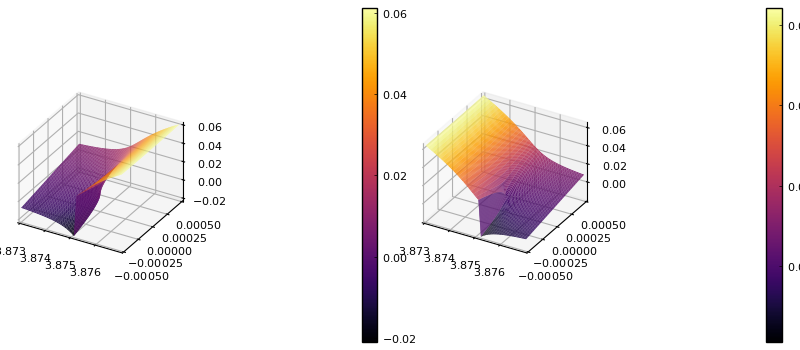

In [15]:
let Ev=collect(3.873:0.0001:3.877),Γv=collect(-500e-6:10e-6:500e-6)
    resv=[qon_c(e+im*γ) for γ in Γv,e in Ev]
    p1=surface(Ev,Γv,real.(resv))
    p2=surface(Ev,Γv,imag.(resv))
    plot(p1,p2,layout=(1,2),size=(800,350))
end

# path deformation

In [8]:
xxx,www=gauss(30,0,1);

In [9]:
function Einner(E,q,m1,m2,m3,m12)
    return E+m12-sqrt(m12^2+q^2+0im)-sqrt(m3^2+q^2+0im)
end

Einner (generic function with 1 method)

In [10]:
function find_qint(E,m1,m2,m3,m12;rtol=1e-6)
    function f!(F,x)
        q=x[1]+1.0im*x[2]
        tmp=Einner(E,q,m1,m2,m3,m12)
        F[1]=real(tmp)-m1-m2
        F[2]=imag(tmp)-rtol
    end
    sol=NLsolve.nlsolve(f!,[0.1,-0.1])
    return sol.zero[1]+im*sol.zero[2]
end

find_qint (generic function with 1 method)

$0\sim 0.5$, $0.5\sim 1$, $1\sim\infty$

In [11]:
f1(x)=0.5*x;
f2(x)=0.5*(1-x)+1.0*x;
f3(x)=1.0+tan(π/2*x);
df3(x)=π/2/cos(π/2*x)^2;

In [12]:
function find_qw(E)
    # wi is the one wrappered with g'(x)
    qon=[qon_c(E),qon_0(E)]
    if imag(E)>=0||(real(E)<=mDn+mDn+mπc)
        qi=vcat(f1.(xxx),f2.(xxx),f3.(xxx))
        wi=vcat(0.5 .*www,0.5 .*www,df3.(xxx) .*www)
        return qon,qi,wi
    end
    # find closet DDπ
    qint1,qint2=zeros(ComplexF64,2)
    if real(E)>mDc+mDc+mπc
        qint1=find_qint(E,mDc,mπc,mDc,mDsn)
        qint2=find_qint(E,mDn,mπc,mDn,mDsc)
    elseif real(E)>mDc+mDn+mπn
        qint1=find_qint(E,mDc,mπn,mDn,mDsc)
        qint2=find_qint(E,mDn,mπc,mDn,mDsc)
    else
        qint1=find_qint(E,mDn,mπc,mDn,mDsc)
        qint2=2*real(qint1)
    end
    
    @assert real(qint1)>0&&imag(qint1)<0 "Wrong qint1 position!"
    @assert imag(qint2)>imag(qint1)&&imag(qint2)<=0&&real(qint2)>real(qint1) "Wrong qint2 position!"
    println(qint1,qint2)
    # get points
    qint3=Roots.find_zero(x->imag(conj(qint2-qint1)*(x-qint1)),(0,Inf))
    
    qi=vcat(qint1 .*xxx,qint1 .+ ((qint3-qint1) .*xxx),qint3 .+(tan.(π/2 .*xxx)))
    wi=vcat(qint1 .*www,(qint3-qint1) .*www,df3.(xxx) .*www)
    return qon,qi,wi
end

find_qw (generic function with 1 method)

0.10142601913659079 - 0.00023878108770958398im0.1030972153643312 - 0.0002349212081016791im


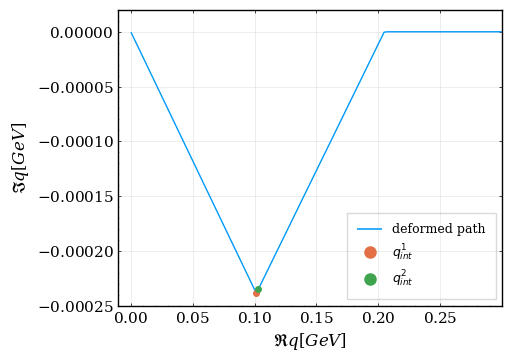

In [52]:
let E=mDn+mDsc-360e-6-im*24e-6
    qon,qi,wi=find_qw(E)
    plot(real.(qi),imag.(qi),xlims=(-0.01,0.3),ylims=(-0.00025,0.00002),xlabel=L"\Re q[GeV]",ylabel=L"\Im q[GeV]",label="deformed path",legend=:bottomright)
    scatter!([0.10142601913659079],[-0.00023878108770958398],label=L"q_{int}^1")
    scatter!([0.1030972153643312],[-0.0002349212081016791],label=L"q_{int}^2")
    savefig("./images/deformed_path.png")
end

0.10142601913659079 - 0.00023878108770958398im0.1030972153643312 - 0.0002349212081016791im


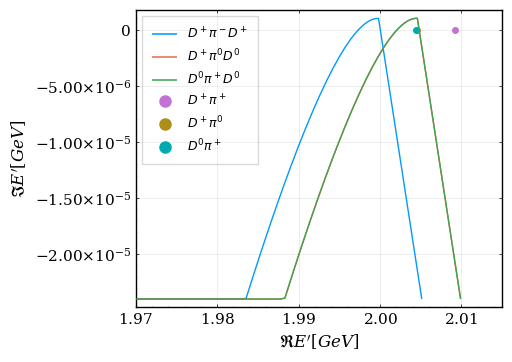

In [61]:
let E=mDn+mDsc-360e-6-im*24e-6
    qon,qi,wi=find_qw(E)
    path1=broadcast(q->Einner(E,q,mDc,mπc,mDc,mDsn),qi)
    path2=broadcast(q->Einner(E,q,mDc,mπn,mDn,mDsc),qi)
    path3=broadcast(q->Einner(E,q,mDn,mπc,mDn,mDsc),qi) 
    @assert real(E)>mDc+mDn+mπn&&real(E)<2*mDc+mπc "Wrong position!"
    plot(xlims=[1.97,2.015],xlabel=L"\Re E'[GeV]",ylabel=L"\Im E'[GeV]",legend=:topleft)
    plot!(real.(path1),imag.(path1),label=L"D^+\pi^-D^+")
    plot!(real.(path2),imag.(path2),label=L"D^+\pi^0D^0")
    plot!(real.(path3),imag.(path3),label=L"D^0\pi^+D^0")
    scatter!([mDc+mπc],[0.0],label=L"D^+\pi^+")
    scatter!([mDc+mπn],[0.0],label=L"D^+\pi^0")
    scatter!([mDn+mπc],[0.0],label=L"D^0\pi^+")
    savefig("./images/deformed_path_1.png")
end

In [13]:
function find_qw1(E)
    # wi is the one wrappered with g'(x)
    qon=[qon_c(E),qon_0(E)]
    if imag(E)>=0||(real(E)<=mDn+mDn+mπc)
        qi=vcat(qon,f1.(xxx),f2.(xxx),f3.(xxx))
        wi=vcat(0.5 .*www,0.5 .*www,df3.(xxx) .*www)
        return qi,wi
    end
    # find closet DDπ
    qint1,qint2=zeros(ComplexF64,2)
    if real(E)>mDc+mDc+mπc
        qint1=find_qint(E,mDc,mπc,mDc,mDsn)
        qint2=find_qint(E,mDn,mπc,mDn,mDsc)
    elseif real(E)>mDc+mDn+mπn
        qint1=find_qint(E,mDc,mπn,mDn,mDsc)
        qint2=find_qint(E,mDn,mπc,mDn,mDsc)
    else
        qint1=find_qint(E,mDn,mπc,mDn,mDsc)
        qint2=2*real(qint1)
    end
    
    @assert real(qint1)>0&&imag(qint1)<0 "Wrong qint1 position!"
    @assert imag(qint2)>imag(qint1)&&imag(qint2)<=0&&real(qint2)>real(qint1) "Wrong qint2 position!"
    
    # get points on real axis
    qint3=Roots.find_zero(x->imag(conj(qint2-qint1)*(x-qint1)),(0,Inf))
    
    qi=vcat(qon,qint1 .*xxx,qint1 .+ ((qint3-qint1) .*xxx),qint3 .+(tan.(π/2 .*xxx)))
    wi=vcat(qint1 .*www,(qint3-qint1) .*www,df3.(xxx) .*www)
    return qi,wi
end

find_qw1 (generic function with 1 method)

In [14]:
function VMat(E;a = 0.0)
    vmat=zeros(ComplexF64,4,4)
    k1,k2=qon_c(E),qon_0(E)
    vmat[1,1] = potential_DnDsc(E,k1,k1; a = a, cl = :ss)
    vmat[1,2] = potential_DnDsc(E,k1,k1; a = a, cl = :ds)
    vmat[2,1] = potential_DnDsc(E,k1,k1; a = a,  cl = :sd)
    vmat[2,2] = potential_DnDsc(E,k1,k1; a = a, cl = :dd)
    vmat[1,3] = potential_DDscross(E,k2,k1; a = a,  cl = :ss)
    vmat[1,4] = potential_DDscross(E,k2,k1; a = a,  cl = :ds)
    vmat[2,3] = potential_DDscross(E,k2,k1; a = a,  cl = :sd)
    vmat[2,4] = potential_DDscross(E,k2,k1; a = a,  cl = :dd)
    vmat[3,1] = potential_DDscross(E,k1,k2; a = a,  cl = :ss)
    vmat[3,2] = potential_DDscross(E,k1,k2; a = a,  cl = :ds)
    vmat[4,1] = potential_DDscross(E,k1,k2; a = a,  cl = :sd)
    vmat[4,2] = potential_DDscross(E,k1,k2; a = a,  cl = :dd)
    vmat[3,3] = potential_DcDsn(E,k2,k2; a = a,  cl = :ss)
    vmat[3,4] = potential_DcDsn(E,k2,k2; a = a,  cl = :ds)
    vmat[4,3] = potential_DcDsn(E,k2,k2; a = a,  cl = :sd)
    vmat[4,4] = potential_DcDsn(E,k2,k2; a = a,  cl = :dd)
    return vmat
end

VMat (generic function with 1 method)

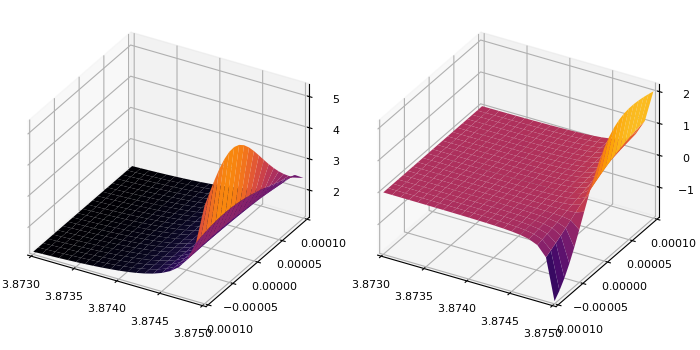

In [26]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps()),Γv=collect(-100e-6:10e-6:100e-6)
    function z0(E)
        k1=qon_c(E)
        q0=q0f(E, mDn, mDsc, mDsc, mDn)
        (k1^2+k1^2+mπc^2 - q0^2)/(2*k1^2)
    end

    resv=[z0(e+im*γ) for γ in Γv,e in Ev]
    p1=surface(Ev,Γv,real.(resv),legend=:false)
    p2=surface(Ev,Γv,imag.(resv),legend=:false)
    plot(p1,p2,layout=(1,2),size=(700,350))
end

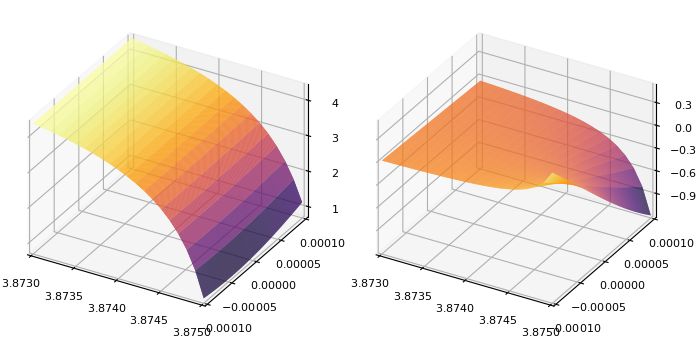

In [27]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps()),Γv=collect(-100e-6:1e-6:100e-6)
    function tmpf(E)
        k1=qon_c(E)
        potential_DnDsc(E,k1,k1)
    end
    resv=[tmpf(e+im*γ) for γ in Γv,e in Ev]
    p1=surface(Ev,Γv,real.(resv),legend=:false)
    p2=surface(Ev,Γv,imag.(resv),legend=:false)
    plot(p1,p2,layout=(1,2),size=(700,350))
end

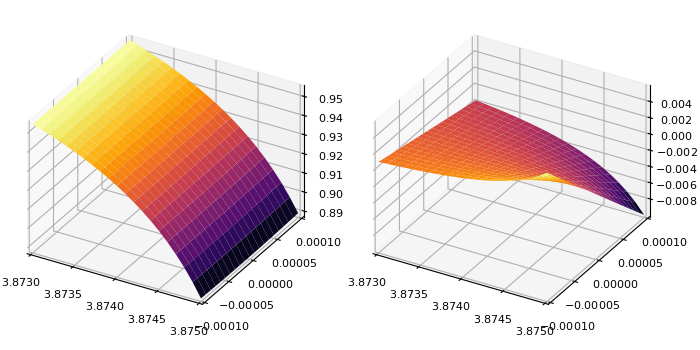

In [28]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps()),Γv=collect(-100e-6:10e-6:100e-6)
    function z0(E)
        k2=qon_0(E)
        q0=q0f(E, mDc, mDsn, mDsn, mDc)
        (k2^2+k2^2+mπc^2 - q0^2)/(2*k2^2)
    end

    resv=[z0(e+im*γ) for γ in Γv,e in Ev]
    p1=surface(Ev,Γv,real.(resv),legend=:false)
    p2=surface(Ev,Γv,imag.(resv),legend=:false)
    plot(p1,p2,layout=(1,2),size=(700,350))
end

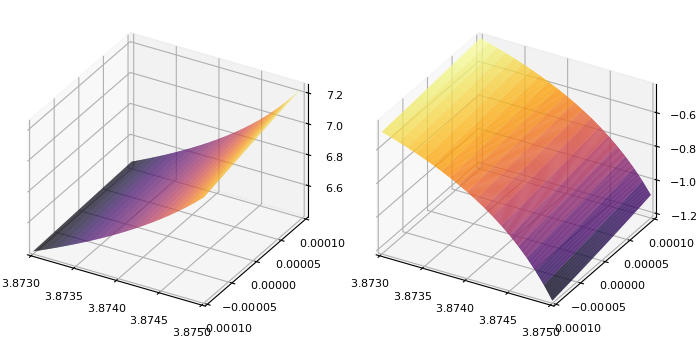

In [29]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps()),Γv=collect(-100e-6:1e-6:100e-6)
    function tmpf(E)
        k2=qon_0(E)
        potential_DcDsn(E,k2,k2)
    end
    resv=[tmpf(e+im*γ) for γ in Γv,e in Ev]
    p1=surface(Ev,Γv,real.(resv),legend=:false)
    p2=surface(Ev,Γv,imag.(resv),legend=:false)
    plot(p1,p2,layout=(1,2),size=(700,350))
end

In [15]:
Gc(E,q)=1/(2π^2)/(E-mDn-mDsc-q^2/(2*μf(mDn,mDsc))+im*ΓDscf(E,q)/2)
Gn(E,q)=1/(2π^2)/(E-mDc-mDsn-q^2/(2*μf(mDc,mDsn))+im*ΓDsnf(E,q)/2)

Gn (generic function with 1 method)

In [16]:
function GMat(E;Λ1=0.5,Λ2=0.5)
    qi,wi=find_qw1(E)
    k1,k2,qau=qi[1],qi[2],qi[3:end]
    μ1,μ2=μf(mDn,mDsc),μf(mDc,mDsn)
    
    g11=sum(broadcast(l->(l^2*exp(-l^2/Λ1^2)-k1^2*exp(-k1^2/Λ1^2))*Gc(E,l),qau) .*wi)+im/(2π)*k1^2*exp(-k1^2/Λ1^2)/(-k1/μ1+im*dΓDscf(E,k1)/2)
    g33=sum(broadcast(l->(l^2*exp(-l^2/Λ2^2)-k2^2*exp(-k2^2/Λ2^2))*Gn(E,l),qau) .*wi)+im/(2π)*k2^2*exp(-k2^2/Λ2^2)/(-k2/μ2+im*dΓDsnf(E,k2)/2)
    return diagm([g11,g11,g33,g33])
end

GMat (generic function with 1 method)

In [32]:
GMat(3.873+im*eps())

4×4 Matrix{ComplexF64}:
 -0.0356572-4.95076e-5im         0.0+0.0im         …         0.0+0.0im
        0.0+0.0im         -0.0356572-4.95076e-5im            0.0+0.0im
        0.0+0.0im                0.0+0.0im                   0.0+0.0im
        0.0+0.0im                0.0+0.0im            -0.0338357-3.5653e-5im

In [33]:
GMat(3.873-im*eps())

4×4 Matrix{ComplexF64}:
 -0.0356571-4.94776e-5im         0.0+0.0im         …         0.0+0.0im
        0.0+0.0im         -0.0356571-4.94776e-5im            0.0+0.0im
        0.0+0.0im                0.0+0.0im                   0.0+0.0im
        0.0+0.0im                0.0+0.0im            -0.0338357-3.5649e-5im

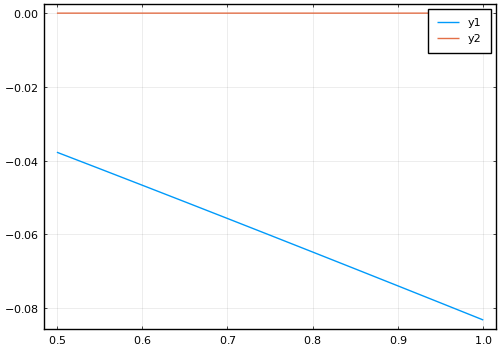

In [34]:
let E=3.874+im*eps(),Λv=collect(0.5:0.05:1.0)
    resv=[GMat(E;Λ1=Λ)[1,1] for Λ in Λv]
    plot(Λv,real.(resv))
    plot!(Λv,imag.(resv))
end

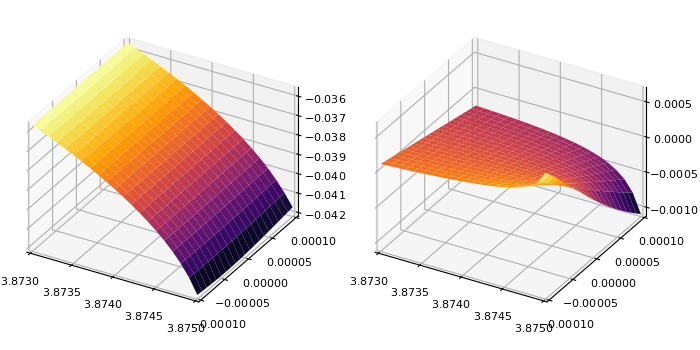

In [35]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps()),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[GMat(e+im*γ)[1,1] for γ in Γv,e in Ev]
    p1=surface(Ev,Γv,real.(resv),legend=:false)
    p2=surface(Ev,Γv,imag.(resv),legend=:false)
    plot(p1,p2,layout=(1,2),size=(700,350))
end

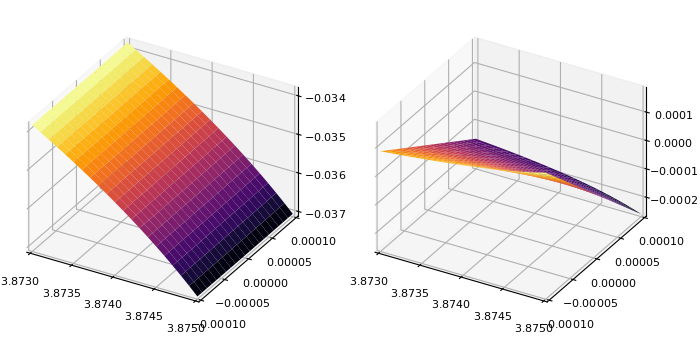

In [36]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps()),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[GMat(e+im*γ)[3,3] for γ in Γv,e in Ev]
    p1=surface(Ev,Γv,real.(resv),legend=:false)
    p2=surface(Ev,Γv,imag.(resv),legend=:false)
    plot(p1,p2,layout=(1,2),size=(700,350))
end

In [17]:
function TMat(E;a = 0.0,Λ1=0.5,Λ2=0.5)
    vv=VMat(E;a=a)
    gg=GMat(E;Λ1=Λ1,Λ2=Λ2)
    return inv(LinearAlgebra.I-vv*gg)*vv
end

TMat (generic function with 1 method)

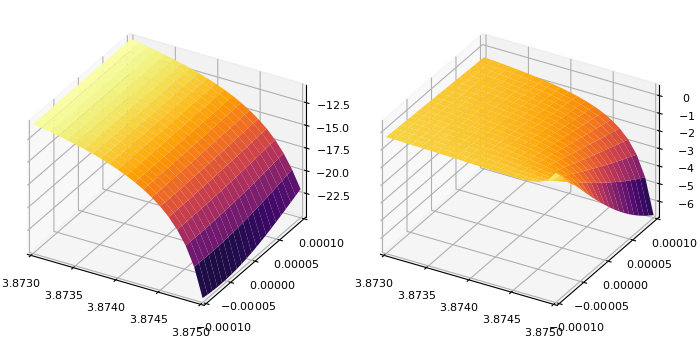

In [38]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps()),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[TMat(e+im*γ)[1,1] for γ in Γv,e in Ev]
    p1=surface(Ev,Γv,real.(resv),legend=:false)
    p2=surface(Ev,Γv,imag.(resv),legend=:false)
    plot(p1,p2,layout=(1,2),size=(700,350))
end

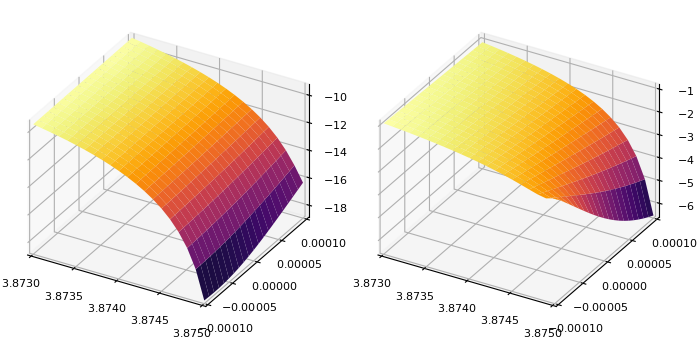

In [39]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps()),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[TMat(e+im*γ)[3,3] for γ in Γv,e in Ev]
    p1=surface(Ev,Γv,real.(resv),legend=:false)
    p2=surface(Ev,Γv,imag.(resv),legend=:false)
    plot(p1,p2,layout=(1,2),size=(700,350))
end

In [18]:
function detVG(E;a = 0.0,Λ1=0.5,Λ2=0.5)
    vv=VMat(E;a=a)
    gg=GMat(E;Λ1=Λ1,Λ2=Λ2)
    return det(LinearAlgebra.I-vv*gg)
end

detVG (generic function with 1 method)

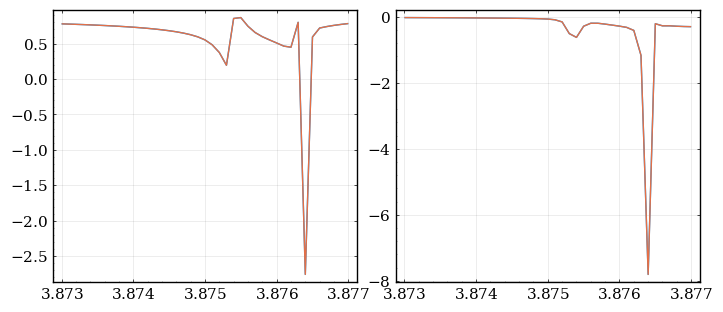

In [20]:
let Ev=collect(3.873:0.0001:3.877)
    resv1=[detVG(e+im*eps()) for e in Ev]
    resv2=[detVG(e-im*eps()) for e in Ev]
    p1=plot(Ev,real.(resv1),legend=:false)
    plot!(Ev,real.(resv2))
    p2=plot(Ev,imag.(resv1),legend=:false)
    plot!(Ev,imag.(resv2))
    plot(p1,p2,layout=(1,2),size=(700,300))
    savefig("./images/ivg.png")
end

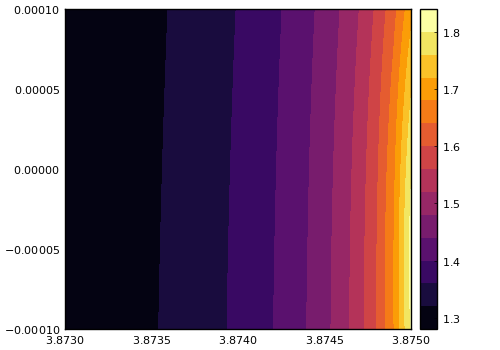

In [43]:
let Ev=collect(3.873:0.0001:mDn+mDsc-eps()),Γv=collect(-100e-6:10e-6:100e-6)
    resv=[1/abs(detVG(e+im*γ)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
end

# optimization

In [44]:
using Optim;

In [45]:
function absdet(x;E=mDn+mDsc-360e-6-im*24e-6)
    return abs(detVG(E;a=x[1],Λ1=x[2],Λ2=x[3]))
end

absdet (generic function with 1 method)

In [46]:
function inv_abst(x;E=mDn+mDsc-360e-6-im*24e-6)
    return 1/abs(TMat(E;a=x[1],Λ1=x[2],Λ2=x[3])[1,1])
end

inv_abst (generic function with 1 method)

In [47]:
function plotdetvg(x)
    Ev=collect(3.873:0.0001:3.877)
    Γv=collect(-500e-6:10e-6:500e-6)
    resv=[1/abs(detVG(e+im*γ;a=x[1],Λ1=x[2],Λ2=x[3])) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
    vline!([mDn+mDsc],ls=:dot)
    vline!([mDc+mDsn],ls=:dot)
end

plotdetvg (generic function with 1 method)

In [60]:
function plottmatrix(x)
    Ev=collect(3.873:0.00001:3.877)
    resv=[abs(TMat(e;a=x[1],Λ1=x[2],Λ2=x[3])[1,1]) for e in Ev]
    plot(Ev,resv)
    vline!([mDn+mDsc],ls=:dot)
    vline!([mDc+mDsn],ls=:dot)
end

plottmatrix (generic function with 1 method)

In [48]:
function searchminumum(x)
    loss(y)=abs(detVG(y[1]+im*y[2];a=x[1],Λ1=x[2],Λ2=x[3]))
    init_val=[mDn+mDsc-360e-6,-24e-6]
    lower=[mDn+mDsc-400e-6,-100e-6]
    upper=[mDn+mDsc-200e-6,-10e-6]
    res=Optim.optimize(loss,lower,upper,init_val)
    return Optim.minimum(res),Optim.minimizer(res)
end

searchminumum (generic function with 1 method)

## same $\Lambda$ and a=0

In [49]:
let 
    tmpf(x)=absdet([0.0,x[1],x[1]])
#     tmpf(x)=inv_abst([0.0,x[1],x[1]])
    init_val=[0.6]
    lower=[0.5]
    upper=[1.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.07034329631337477
[0.7301346084388464]


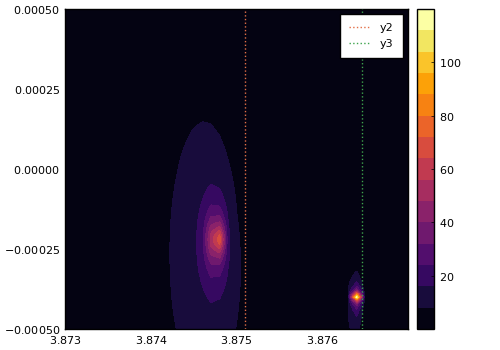

In [50]:
plotdetvg([0.0,0.7307998811057776,0.7307998811057776])

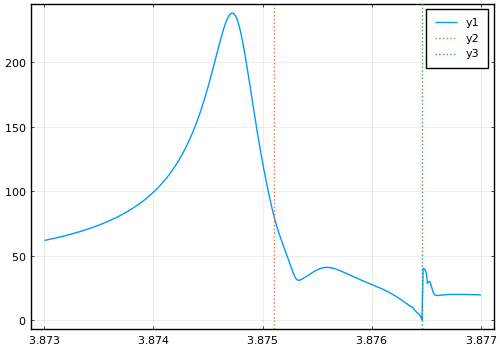

In [68]:
plottmatrix([0.0,0.7307998811057776,0.7307998811057776])

In [51]:
let 
    tmpf(x)=absdet([0.0,x[1],x[1]])
    init_val=[0.5]
    lower=[0.1]
    upper=[2.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.07034329631337474
[0.7301346084415371]


## diff $\Lambda$ and a=0

In [52]:
let 
#     tmpf(x)=absdet([0.0,x[1],x[2]])
    tmpf(x)=inv_abst([0.0,x[1],x[2]])
    init_val=[0.5,0.5]
    lower=[0.1,0.1]
    upper=[2.0,2.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.0037484720645349916
[0.6844388681389538, 0.7892007787083479]


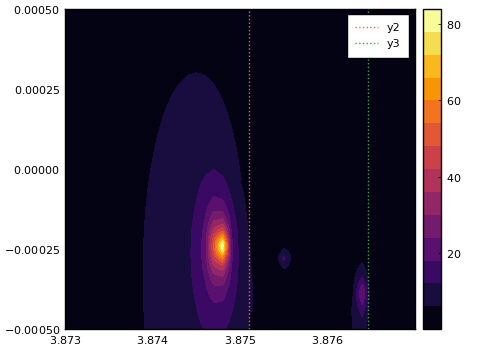

In [53]:
plotdetvg([0.0,0.6844388681389538, 0.7892007787083479])

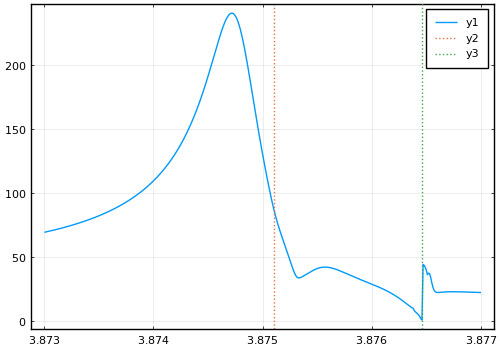

In [62]:
plottmatrix([0.0,0.6844388681389538, 0.7892007787083479])

## diff $\Lambda$ and 0-a-1

In [54]:
let 
#     tmpf(x)=absdet([x[1],x[2],x[3]])
    tmpf(x)=inv_abst([x[1],x[2],x[3]])
    init_val=[0.01,0.6,0.6]
    lower=[0.0,0.5,0.5]
    upper=[1.0,1.0,1.0]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.00027338410153024406
[0.9999999987880434, 0.6369747306176949, 0.5000000020521512]


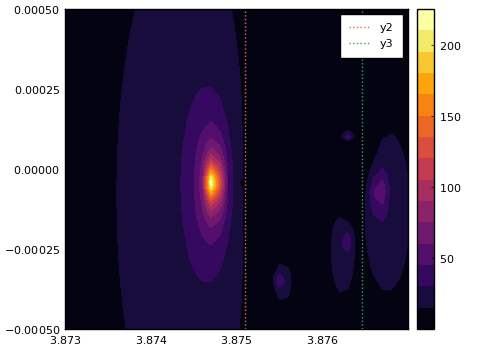

In [55]:
plotdetvg([0.9999999987880434, 0.6369747306176949, 0.5000000020521512])

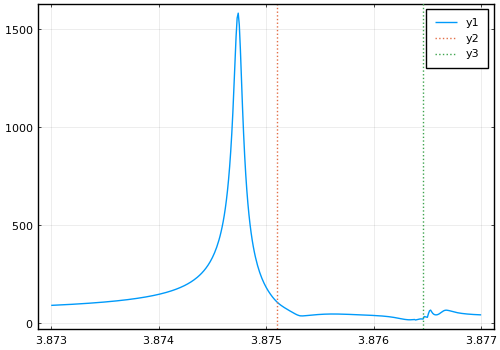

In [63]:
plottmatrix([0.9999999987880434, 0.6369747306176949, 0.5000000020521512])

In [64]:
let 
#     tmpf(x)=absdet([x[1],x[2],x[3]])
    tmpf(x)=inv_abst([x[1],x[2],x[3]])
    init_val=[0.01,0.6,0.6]
    lower=[0.0,0.5,0.5]
    upper=[1.0,1.5,1.5]
    res=Optim.optimize(tmpf,lower,upper,init_val)
    println(Optim.minimum(res))
    println(Optim.minimizer(res))
end

0.00027338410162279525
[0.9999999987607245, 0.6369747306266654, 0.5000000020984066]


In [66]:
GMat(3.875;Λ1=0.55)

4×4 Matrix{ComplexF64}:
 -0.046505-0.000295142im        0.0+0.0im          …         0.0+0.0im
       0.0+0.0im          -0.046505-0.000295142im            0.0+0.0im
       0.0+0.0im                0.0+0.0im                    0.0+0.0im
       0.0+0.0im                0.0+0.0im             -0.0370484-3.82878e-5im